In [1]:
function extract_J(V,W)

    coshu = sqrt(V*V');
    exp_phi = inv(coshu) * V;

    F, coshr, X = svd(coshu);

    nel = length(coshr);
    print(nel)
    r = zeros(nel);

    for i in 1:nel
        if abs(coshr[i]  - 1.0) < 1.0e-4
            coshr[i] = 1.0;
            #print("== $(coshr[i])");
        end
        r[i] = acosh(coshr[i]);
    end

    #check that X=F
    Fcheck = sum(sum(F - X));

    if abs(Fcheck)>1.0e-10
        println("F neq X");
        print(Fcheck)
    end

    sinhr = sinh.(r);

    Kinv_eig = zeros(nel);
    K_eig = zeros(nel);

    for i in 1:nel
        if r[i] < 1e-12
            Kinv_eig[i] = 1.0;
            K_eig[i] = 1.0;
        else
            Kinv_eig[i] = r[i]/sinhr[i];
            K_eig[i] = sinhr[i]/r[i];
        end
    end

    Kinv = F*diagm(Kinv_eig)*F';
    K = F*diagm(K_eig)*F';

    J = Kinv*(W*transpose(exp_phi));

    return J, exp_phi, r;

end

function nonlinear_coeff(t)

    Lambda = zeros(Complex{Float64}, n,n,nPk);
    Lambda0 = zeros(Complex{Float64}, nSk,nSk,nPk); #baseline nonlinear coefficient common to all channels

    FS1_amp = sqrt(4.0*vg*Q_S/(2.0*pi*R*wS)); #notice that the coupling efficiency eta is not here, because it's different for each channel
    FS2_amp = sqrt(4.0*vg*Q_S/(2.0*pi*R*wS)); #notice that the coupling efficiency eta is not here, because it's different for each channel
    FP_amp = sqrt(4.0*vg*Q_P*eta_P/(2.0*pi*R*wP)); #recall eta is coupling to real channel
    FC_amp = sqrt(4.0*vg*eta_C*Q_C/(2.0*pi*R*wC)) * 1im;

    mfact = -(2.0*pi/L)^(1.5)*(1/(4.0*pi^2))*hbar*vg^2*gamma_nl*wS*(2.0*pi*R)*sqrt(2.0*pi*PC/(hbar*wC*vg))*FS1_amp*FS2_amp*FP_amp*FC_amp;

    for idx1 in 1:nSk
        arg1 = xS[idx1];
    
        for idx2 in 1:nSk
             arg2 = xS[idx2];

            for idx3 in 1:nPk
                arg3 = xP[idx3];
        
                Lambda0[idx1,idx2,idx3] = 1/(-arg1 - 1im) * 1/(-arg2-1im)* 1/(-arg3-1im)  * exp(-1im*(arg3*GammaP/GammaS - arg1 - arg2)*t);
             
            end
        end
    end

    #construct lambda (2*nSk x 2*nSk) for the case where n=0,1, i.e., two output channels
    #can generalize this bit of code later for any number of output channels
    Lambda[1:nSk,1:nSk,:] = Lambda0.*eta_S;
    Lambda[1:nSk,nSk+1:2*nSk,:] = Lambda0.*sqrt(eta_S*(1-eta_S));
    Lambda[nSk+1:2*nSk,1:nSk,:] = Lambda0.*sqrt(eta_S*(1-eta_S));
    Lambda[nSk+1:2*nSk,nSk+1:2*nSk,:] = Lambda0.*(1-eta_S);

    return mfact*Lambda;

end

function solve_ode(u0, tspan)

    function ode!(du,u,p,t)

        V_vec = u[1:n*n];
        W_vec = u[n*n+1:2*n*n];
        beta = u[2*n*n+1:2*n*n+nPk];

        V = reshape(V_vec,n,n);
        W = reshape(W_vec, n,n);

        spdc = nonlinear_coeff(t);

        #build the Zeta matrix from spdc
        Zeta = zeros(Complex{Float64}, n,n);
        for idx2 in 1:n
            for idx3 in 1:n

                #Zeta[idx2, idx3] = transpose(spdc[idx2, idx3, :])*beta;
                for idx4 in 1:nPk
                Zeta[idx2, idx3] += spdc[idx2, idx3, idx4]*beta[idx4];
                end

            end
        end

        #build the gammadis matrix from spdc, V, and W
        gammadis = zeros(Complex{Float64}, nPk);
        for idx2 in 1:nPk
            
            gammadis[idx2] = sum(conj(spdc[:,:,idx2]).*(V*transpose(W)));
     
        end

    
        dbeta = -1im*gammadis / GammaS;    
        dV = -2.0*1im * Zeta * conj(W) / GammaS;
        dW = -2.0*1im * Zeta * conj(V) / GammaS;
    
        du[1:n*n] .= dV[:];
        du[n*n+1:2*n*n] .= dW[:];
        du[2*n*n+1:2*n*n+nPk] .= dbeta;
    end

    prob = ODEProblem(ode!, u0, tspan);
    sol = solve(prob,Tsit5());
  
    return sol;
end

function nph_tot(u)
    #this function calcualtes the total photon number from the solution (sol) at each time
    #and returns a vector with the same length as the time vector
    Nt = length(tode);
    nphS = zeros(Nt);
    nphP = zeros(Nt);

    for idx1 in 1:Nt
        u_now = u[idx1];
        V_now = reshape(u_now[1:n*n],n,n);
        W_now = reshape(u_now[n*n+1:2*n*n],n,n);
        beta_now = u_now[2*n*n+1:2*n*n+nPk];

        nphS[idx1] = (tr(W_now'*W_now));
        nphP[idx1] = beta_now'*beta_now;
    end

    return nphS, nphP;

end

function correlation2_k(V, W)
    #this function calculates the G^(2) correlation function for the squeezed light in k-space
    G2 = zeros(Complex{Float64}, nSk,nSk);
    C1 = conj(W)*V';
    C2 = W*transpose(V);
    C3 = W*W';
    C4 = conj(W)*transpose(W); 

    for idx1 in 1:nSk
        for idx2 in 1:nSk

            G2[idx1,idx2] = C1[idx1,idx2]*C2[idx1,idx2] ;
            + C3[idx1,idx1]*C3[idx2,idx2] ;
            + C4[idx1,idx2]*C3[idx1,idx2]; 

        end
    end

    return G2;

end

function correlation2_t(V, W, t1, t2, z1, z2)
    #this function calculates the G^(2)_00 correlation function for the squeezed light in time
   
    C1 = conj(W)*V';
    C2 = W*transpose(V);
    C3 = conj(W)*transpose(W); 

    #cut out part to do with real channel
    C1 = C1[1:nSk, 1:nSk];
    C2 = C2[1:nSk, 1:nSk];
    C3 = C3[1:nSk, 1:nSk];

    T1 = exp.(-1im.*xS.*(GammaS*z1/vg - t1));
    T2 = exp.(-1im.*xS.*(GammaS*z2/vg - t2));


    G2 =( transpose(T1)*C1*T2 ) * ( T1'*C2*conj(T2) ) + ( transpose(T1)*C3*conj(T1) ) * ( transpose(T2)*C3*conj(T2) ) + ( transpose(T1)*C3*conj(T2) ) * ( transpose(T2)*C3*conj(T1) );



    return G2./L^2;

end

function correlation1_t(W, t, z)
    #this function calculates the G^(1)_00 correlation function for the squeezed light in time

    C = conj(W)*transpose(W); 

    #cut out part to do with real channel
    C = C[1:nSk, 1:nSk];

    T = exp.(-1im.*xS.*(GammaS*z/vg - t));
   


    G1 = transpose(T)*C*conj(T);

    return G1./L;

end

function JTA(J,z)
    Nz = length(z);
    Jz = zeros(Complex{Float64}, Nz,Nz);

    for idx1 in 1:Nz
        T1 = exp.(-1im*xS.*(GammaS/vg * z[idx1]));
        for idx2 in 1:Nz
            T2 = exp.(-1im*xS.*(GammaS/vg * z[idx2]));

            Jz[idx1, idx2] = transpose(T1)*J*T2;
        end
    end

    return Jz;
end

JTA (generic function with 1 method)

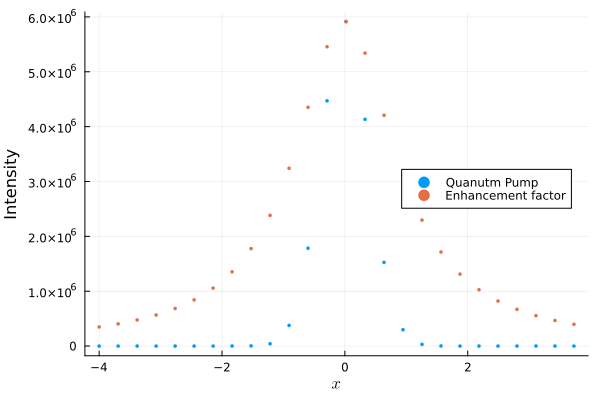

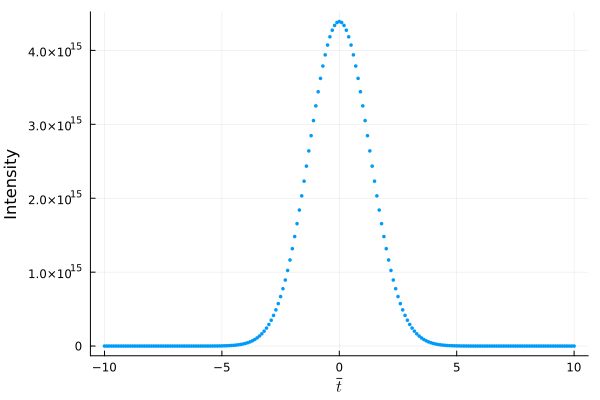

Number of k modes in S = 26 
Number of k modes in P = 26 
Number of output channels = 2 
Classical pump power = 30.0 mW
Quantum pump duration = 3.0 ns
Quantum pump coupling efficiency to real channel = 0.5
Classical pump coupling efficiency to real channel = 0.5
Squeezed light coupling efficiency to real channel = 0.5
Intrinsic Q = 2.0e6
Loaded Q = 1.0e6


[ Info:  started timer at: 2024-02-26T14:11:10.793
[ Info:         16.289797542s: 16 seconds, 289 milliseconds


52

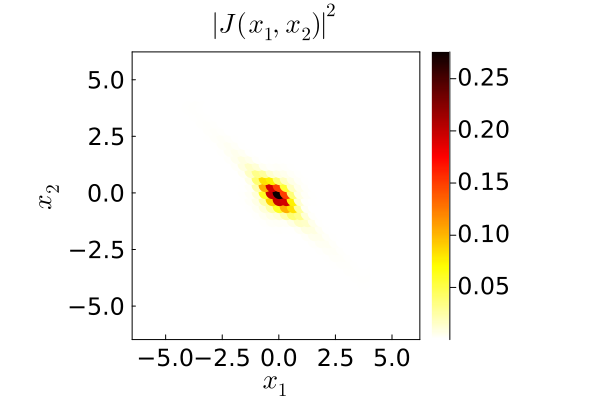

Number of generated photons = 134.3821089915123
Schmidt number = 1.0362234584528067
Final number of quantum pump photons = 2.334458705762267e7
Pump depletion ratio = 0.0002878165534347943%
Conversion efficiency = 0.0005756440321084125%
Initial total photon number = 2.3344654247401938e7
Final total photon number = 2.3344654248677168e7
Total photon number conserved?  percent. diff = 5.462621915703373e-9%


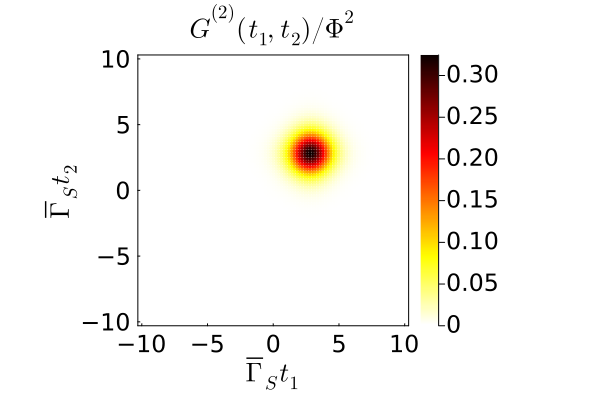

In [4]:
using DifferentialEquations
using LinearAlgebra
using Plots 
using TickTock
using Trapz
using LaTeXStrings
using JLD2

c = 299792458;
hbar = 1.05457182e-34;
gamma_nl = 1.0; #nonlinear parameter for SiN units of (Wm)^-1
eta_S = 0.5; #squeezed light coupling efficiency to the real channel
eta_P = 0.5; #quantum pump coupling efficiency to the real channel
eta_C = 0.5; #classical coupling efficiency to the real channel
Q_int = 2e6; #intrinsic quality factor
Q_S = (1-eta_S)*Q_int; # S loaded quality factor
Q_P = (1-eta_P)*Q_int; # quantum pump P loaded quality factor
Q_C = (1-eta_C)*Q_int; # classical pump C loaded quality factor


R = 45.0e-6; #ring radius
neff = 1.8; #effective index for SiN around 1550 nm
ng = 2.0; #group index for SiN around 1550 nm
vg = c/ng; #group velocity
fsr = vg/(2*pi*R); #free spectral range
TR = 2*pi*R*neff/c; #ring round trip time
lambdaS = 1550.0e-9; #wavelength for squeezed light
fS = c/lambdaS; #frequency of squeezed light
fC = fS - fsr; #frequency of classical pump C
fP = fS + fsr; #frequency of quantum pump P
wS = 2.0*pi*fS; # angular frequency of squeezed light
wP = 2.0*pi*fP; # angular frequency of quantum pump P
wC = 2.0*pi*fC; # angular frequency of classical pump C
lambdaP = c/fP; #wavelength of quantum pump P
lambdaC = c/fC; #wavelength of classical pump Csqrt
PC = 30.0e-3; #power of classical pump C
tauP = 3.0e-9; #duration of quantum pump P
UP = 3.0e-12; #energy of quantum pump P
Nph = UP/(hbar *wP); # number of photons in P

GammaS = wS/(2*Q_S); #tot decay rate for squeezed light
GammaC = wC/(2*Q_C); #tot decay rate for classical pump C
GammaP = wP/(2*Q_P); #tot decay rate for quantum pump P

KS = 2.0*pi*neff/lambdaS; #center K for squeezed light
KP = 2.0*pi*neff/lambdaP; #center K for quantum pump
KC = 2.0*pi*neff/lambdaC; #center K for classical pump

#setup k vectors
x0_S = 4.0; #absolute limit for the dimensionless variable xS
x0_P = 4.0; #absolute limit for the dimensionless variable xP
x0_C = 4.0; #absolute limit for the dimensionless variable xC
#min/max k for each resonance
kS_min = - GammaS/vg * x0_S  + KS; 
kS_max =   GammaS/vg * x0_S  + KS; 
kP_min = - GammaP/vg * x0_P  + KP; 
kP_max =   GammaP/vg * x0_P  + KP; 
kC_min = - GammaC/vg * x0_C  + KC; 
kC_max =   GammaC/vg * x0_C  + KC;
L = 5.0 ; #normalization length 
dk = 2.0*pi/L; #wavevector spacing
kS = collect(range(kS_min, kS_max, step = dk));
kP = collect(range(kP_min, kP_max, step = dk));
kC = collect(range(kC_min, kC_max, step = dk));
nSk = length(kS); #number of k modes for S resonance
nPk = length(kP); #number of k modes for P resonance
nCk = length(kC); #number of k modes for C resonance

#setup x vectors
xS = (vg / GammaS) * (kS .- KS);
xP = (vg / GammaP) * (kP .- KP);
xC = (vg / GammaC) * (kC .- KC);
dx = xS[2]-xS[1]; 
x_min = minimum(xS);
x_max = maximum(xS);

nch = 2; #number of output channels, 1 real and 1 phantom

#plot the initial quantum pump pulse and field enhancement factor in x space
pulse = sqrt(UP/(hbar*wP))*sqrt(vg*tauP/sqrt(pi)) * exp.(-0.5*GammaP^2*tauP^2*xP.^2);
Fenh = maximum(pulse.^2)*( xP.^2 .+ 1.0).^(-1);

px =scatter(xP, [pulse.^2, Fenh], markerstrokewidth=0, ms = 2, xlabel=L"x", ylabel = "Intensity", labels=["Quanutm Pump" "Enhancement factor"], legend=:right)


#plot the quantum pump pulse in time
#set up time array
tbar_min = -10.0; #very early time  when there is no nonlinear interaction
tbar_max = 10.0; #very late time when there is no nonlinear interaction
time = collect(range(tbar_min, tbar_max, step = 0.1));


pulse_t = sqrt(UP/(hbar*wP))*1/sqrt(sqrt(pi) * tauP) * exp.(-0.5*time.^2/(tauP^2*GammaS^2)) ;


pt =scatter(time, pulse_t.^2,
markerstrokewidth=0,
ms = 2, 
xlabel=L"\overline{t}", 
ylabel = "Intensity", 
legend= false
)


#display the plot
display(px);

display(pt);

#initial matrices for V and W and beta at t = 0
n = nSk*nch; #dimension of V and W
V0 = Matrix{Float64}(I,n,n).+0.0im;
W0 = zeros(n,n);
NP = round(Int, nPk/2); #index for the peak of pump P
beta0 = sqrt(UP/(hbar*wP))*sqrt(2.0*pi/L)*sqrt(vg*tauP/sqrt(pi)) * exp.(-0.5*GammaP^2*tauP^2*xP.^2);

u0 = [V0[:]; W0[:]; beta0];
tspan = (tbar_min, tbar_max);

################################################

println("Number of k modes in S = $nSk ")
println("Number of k modes in P = $nPk ")
println("Number of output channels = $nch ")
println("Classical pump power = $(PC*1e3) mW")
println("Quantum pump duration = $(1e9*tauP) ns")
println("Quantum pump coupling efficiency to real channel = $eta_P")
println("Classical pump coupling efficiency to real channel = $eta_C")
println("Squeezed light coupling efficiency to real channel = $eta_S")
println("Intrinsic Q = $Q_int")
println("Loaded Q = $Q_P")

################################################

#solve the ODEs for V and W. Also measure how long it takes. 

tick()
sol = solve_ode(u0, tspan);
tock()

#unpack the solution
tode = sol.t;
ntode = length(tode);
u = sol.u;

u1 = u[end];
V1 = reshape(u1[1:n*n],n,n);
W1 = reshape(u1[n*n+1:2*n*n],n,n);
beta1 = u1[2*n*n+1:2*n*n+nPk];


#calculate the total photon number in S and P at the end for all channels
nphP = real(beta1'*beta1);
nphS = real(tr(W1'*W1));
ntot = 0.5*nphS + nphP;


#check that the two contraints are satisfied
check1 = V1*V1' - W1*W1';
check2 = V1*transpose(W1) - W1*transpose(V1);

#extract the parameters of the squeezed state 
J, exp_phi, r = extract_J(V1, W1);


#Schmidt number at the final time, as defined in arXiv 2209.13491
K=(real(nphS))^2/sum(sinh.(r).^4);





J00 = J[1:nSk,1:nSk]; #part of J matrix in: real channel
J01  = J[1:nSk, nSk+1:2*nSk]; #mixed
J10 = J[nSk+1:2*nSk, 1:nSk]; #mixed
J11 = J[nSk+1:2*nSk, nSk+1:2*nSk]; #phantom channel

exp_phi00 = exp_phi[1:nSk,1:nSk]; #part of exp_phi matrix in: real channel
exp_phi01  = exp_phi[1:nSk, nSk+1:2*nSk]; #mixed
exp_phi10 = exp_phi[nSk+1:2*nSk, 1:nSk];
exp_phi11 = exp_phi[nSk+1:2*nSk, nSk+1:2*nSk]; #phantom channel




#do a scatter plot of the squeezing matrix J at the final time
# versus the dimensionless parameters x1 and x2.
XX = repeat(xS, outer = [1,nSk]);
#maxcolor = maximum(abs.(J00).^2);

p00 =  scatter(XX,XX', marker_z = (abs.(J00)).^2,
legend = false, 
colorbar=true,
#clims = (0,maxcolor),
msw = 0, 
ms = (19*1.3*dx), 
color = cgrad(:hot, rev=true),
aspect_ratio=:equal, 
xlabel=L"x_1", 
ylabel=L"x_2", 
titlefontsize = 18, 
guidefontsize=18, 
tickfontsize = 16,
right_margin = 20Plots.mm,
top_margin = 4Plots.mm,
framestyle = :box, 
grid=false,
title=L"|J(x_1,x_2)|^2",
#xticks = x_min:2:x_max,
#yticks = x_min:2:x_max,
xlimits = (x_min-8*dx,x_max+8*dx),
ylimits = (x_min-8*dx,x_max+8*dx)
)

p01 =  scatter(XX,XX', marker_z = (abs.(J01)).^2,
legend = false, 
colorbar=true,
#clims = (0,maxcolor),
msw = 0, 
ms = (19*1.3*dx), 
color = cgrad(:hot, rev=true),
aspect_ratio=:equal, 
xlabel=L"x_1", 
ylabel=L"x_2", 
titlefontsize = 18, 
guidefontsize=18, 
tickfontsize = 16,
right_margin = 20Plots.mm,
top_margin = 4Plots.mm,
framestyle = :box, 
grid=false,
title=L"|J(x_1,x_2)|^2",
xticks = x_min:2:x_max,
yticks = x_min:2:x_max,
xlimits = (x_min-8*dx,x_max+8*dx),
ylimits = (x_min-8*dx,x_max+8*dx)
)

p11 =  scatter(XX,XX', marker_z = (abs.(J11)).^2,
legend = false, 
colorbar=true,
#clims = (0,maxcolor),
msw = 0, 
ms = (19*1.3*dx), 
color = cgrad(:hot, rev=true),
aspect_ratio=:equal, 
xlabel=L"x_1", 
ylabel=L"x_2", 
titlefontsize = 18, 
guidefontsize=18, 
tickfontsize = 16,
right_margin = 20Plots.mm,
top_margin = 4Plots.mm,
framestyle = :box, 
grid=false,
title=L"|J(x_1,x_2)|^2",
xticks = x_min:2:x_max,
yticks = x_min:2:x_max,
xlimits = (x_min-8*dx,x_max+8*dx),
ylimits = (x_min-8*dx,x_max+8*dx)
)

display(p00);
#display(p01);
#display(p11);


#calculate quantum pump depletion
nph0 = real(beta0'*beta0); #initial photon number in quantum pump equal to UP/(hbar * wp)
nph1 = real(beta1'*beta1); #final photon number in quantum pump 
ratio = 1.0 - nph1/nph0;

nph_initial = nph0; # initial total photon number
nph_final = nph1 + 0.5*nphS[end]; # final total photon number


################################################
println("Number of generated photons = $(nphS[end])")
println("Schmidt number = $K")
println("Final number of quantum pump photons = $nph1")
println("Pump depletion ratio = $(100*ratio)%")
println("Conversion efficiency = $(100*nphS/nph0)%")
println("Initial total photon number = $nph_initial")
println("Final total photon number = $nph_final")
println("Total photon number conserved?  percent. diff = $(200*abs(nph_final - nph_initial)/(nph_final+nph_initial))%")
################################################


#calculate the joint temporal amplitude
zaxis = collect(range(-1,1,step =0.05));
JointTA = JTA(J00, zaxis);



#calculate the G2 correlation function in time
Nph = UP/(hbar*wP);
flux = nphS/(vg*tauP);
tG2 = collect(range(-10.0,10.0, step=0.2));
NT = length(tG2);
g200 = zeros(Complex{Float64}, NT, NT);
pos1 = 0.0;
pos2 = 0.0;
G100_1 = zeros(Complex{Float64}, NT);
for idx1 in 1:NT
    time1 = tG2[idx1];
    G100_1[idx1] = correlation1_t(W1, time1, 0.0);

    for idx2 in 1:NT
        time2 = tG2[idx2];
        G100_2 = correlation1_t(W1, time2, 0.0);

        g200[idx1,idx2] = correlation2_t(V1, W1,time1,time2, pos1, pos2)/flux^2;#/(G100_1*G100_2);
    end
end



TT = repeat(tG2, outer = [1,NT]);
maxcolor = maximum(abs.(g200));


#do a scatter plot of G2
pG2 =  scatter(TT,TT', marker_z = real.(g200),
legend = false, 
colorbar=true,
clims = (0,maxcolor),
msw = 0, 
ms = 1.8, 
color = cgrad(:hot, rev=true),
aspect_ratio=:equal, 
xlabel=L"\overline{\Gamma}_S t_1", 
ylabel=L"\overline{\Gamma}_S t_2", 
titlefontsize = 18, 
guidefontsize=18, 
tickfontsize = 16,
right_margin = 20Plots.mm,
top_margin = 4Plots.mm,
bottom_margin = 4Plots.mm,
framestyle = :box, 
grid=false,
title=L"G^{(2)}(t_1,t_2)/\Phi^2",
#xticks = x_min:2:x_max,
#yticks = x_min:2:x_max,
xlimits = (-10.3,10.3),
ylimits = (-10.3,10.3)
)

#plot squeezed photons versus time
#pNS =  scatter(tode, nph_tot(u),
#legend = false, 
#msw = 0,
#ms = 4, 
#aspect_ratio=:equal, 
#xlabel=L"\overline{t}", 
#ylabel=L"\textrm{Generated\,\,} \textrm{photon\,\,} \textrm{number}", 
#titlefontsize = 18, 
#guidefontsize=18, 
#tickfontsize = 16,
#right_margin = 20Plots.mm,
#top_margin = 4Plots.mm,
#framestyle = :box, 
#grid=false,
#xticks = x_min:2:x_max,
#yticks = x_min:2:x_max,
#xlimits = (x_min-8*dx,x_max+8*dx),
#ylimits = (x_min-8*dx,x_max+8*dx)
#)

#display(pNS)
#display(pG2)